In [1]:
import random as random
import Bio
import numpy as np
import sys
import os
import networkx as nx
import random as random
from tqdm import tqdm # loading bar
from utils_copy import linear_C, get_cost_2, get_sequence_string, parse_fasta_multiple, create_score_matrix, write_alignments_to_file, linear_backtrack, fill_graph,new_sp_approxi_combi
from utils_copy import convert_to_desired_format_nr_version, compute_cost, my_traversal_simply, extend_alignment_chaos, find_min_span_edges_testing, parse_fasta_multiple_remove_n
import timeit
from utils_copy import al_integrity_testt
from old_for_testing.sp_approx import sp_approx
from old_for_testing.utils import *
from functions_multiple_version import *
import matplotlib.pyplot as plt
import pandas as pd

score_matrix={'a': {'a': 0, 'c': 5, 'g': 2, 't': 5}, 'c': {'a': 5, 'c': 0, 'g': 5, 't': 2}, 'g': {'a': 2, 'c': 5, 'g': 0, 't': 5}, 't': {'a': 5, 'c': 2, 'g': 5, 't': 0}}
gap_cost=5



In [2]:
def make_related_strings(nr_of_str:int,len_of_str, degree_of_variation:float, start_string):
    string_fam_collection=[]
    first_string=[]
    if start_string==False:
        for k in range(0,random.randrange((len_of_str-1),len_of_str+5)):
                first_string.append(random.choice(['a','c','t','g']))
        first_string=''.join(first_string)
        string_fam_collection.append(first_string)
    else:
         first_string=start_string
         string_fam_collection.append(first_string)

    for i in range(1,nr_of_str):
        a_sequence=[]
        for element in first_string:
            if random.random() < degree_of_variation: #checking if we should change the charachter
                a_sequence.append(random.choice(['a','c','t','g']))
            else:
                 a_sequence.append(element)
        a_sequence=''.join(a_sequence)
        string_fam_collection.append(a_sequence)
    return string_fam_collection

#make_related_strings(3,12,0.1,False)


def make_strings_in_families(nr_of_fams, nr_str_pr_fam, len_of_str, internal_var_in_fams, degree_of_var_from_first_fam):
    all_strings_coll = []
    first_family = make_related_strings(nr_str_pr_fam, len_of_str, internal_var_in_fams[0], start_string=False)
    all_strings_coll.append(first_family)
    
    for i in range(1, nr_of_fams):
        carry_over_string = first_family[0]
        mutated_carry_over = []
        for element in carry_over_string:
            if random.random() < degree_of_var_from_first_fam[i]:  # checking if we should change the character
                mutated_carry_over.append(random.choice(['a', 'c', 't', 'g']))
            else:
                mutated_carry_over.append(element)
        mutated_carry_over = ''.join(mutated_carry_over)  # Join the list of characters into a string
        family = make_related_strings(nr_str_pr_fam, len_of_str, internal_var_in_fams[i],mutated_carry_over)
        all_strings_coll.append(family)
    return all_strings_coll

make_strings_in_families(3, 2, 15, [0.1, 0.1,0.1], [0, 0.9,0.5])


[['gtcaagcctatgttcta', 'gtcaaccctatgttcta'],
 ['aactaagcttgctatct', 'aactacgcttgctatct'],
 ['gtcaaggctattttcta', 'gtcaaggctattttcaa']]

In [14]:
random_sequences_collection=[]
for i in range(0,100):
    random_pile=[]
    for j in range (0,10):
        a_sequence=[]
        for k in range(0,random.randrange(4,10)):
            a_sequence.append(random.choice(['a','c','t','g']))
        a_sequence=''.join(a_sequence)
        random_pile.append(a_sequence)

    random_sequences_collection.append(random_pile)

print(random_sequences_collection)


big_collection_in_families=[]
for x in range(0,20):
    random_sequences_collection_in_fams=make_strings_in_families(3, 5, 15, [0.1, 0.1,0.1], [0, 0.9,0.5])
    #random_sequences_collection_in_fams = [string for sublist in random_sequences_collection_in_fams for string in sublist]
    big_collection_in_families.append(random_sequences_collection_in_fams)
print(big_collection_in_families)

[['tcctccgta', 'gaag', 'tgagcct', 'caaaaat', 'tatt', 'aatccaca', 'aggct', 'gttcccttg', 'ttccac', 'tacgtag'], ['gcaacatg', 'tggtaccgt', 'tatcacg', 'atcgac', 'acaggct', 'tgggtt', 'gctg', 'ggcgagct', 'aaac', 'agttagg'], ['agacaaat', 'gccc', 'tcgat', 'agagtaa', 'gttggcccg', 'cgctgg', 'tgtcac', 'gggcc', 'ctgaagt', 'agcttgt'], ['tcgtgc', 'gtact', 'taccgtc', 'ccttga', 'ttgaaactc', 'ccgacga', 'gcat', 'tgggtgtt', 'ctgaacaca', 'tcgaatcgc'], ['ttgc', 'gtcc', 'gcgatctt', 'gaca', 'caatg', 'tgccaatt', 'ttcctga', 'ccttaag', 'ttcagca', 'tgat'], ['aaaa', 'acggga', 'cgatc', 'acgtagcgg', 'taagacctc', 'aagatgctc', 'cgtctgtct', 'tgtg', 'agttaacca', 'ttcgg'], ['gctaagtga', 'agct', 'ccgc', 'gggg', 'aagggggtt', 'cccac', 'tctca', 'tggaaaa', 'tctag', 'tcaat'], ['tagga', 'cgcaggcg', 'accta', 'ctattccg', 'gctggg', 'ggaactc', 'tcta', 'agtt', 'aattcatac', 'tcctc'], ['taatt', 'gccgta', 'ggctgc', 'cgattcag', 'atacg', 'atagaaca', 'gctgcgt', 'acataa', 'ttctgtcc', 'ggcgttgg'], ['ggagatga', 'agtatg', 'gatag', 'cggatacta'

In [ ]:
costs_new_gradual=[]
costs_new_one_by_one=[]
costs_old=[]

for random_pile in big_collection_in_families:
    cost=new_assembly(random_pile,score_matrix,gap_cost)[4]
    costs_new_gradual.append(cost)
for random_pile in big_collection_in_families:
    cost=new_sp_approxi_combi(random_pile,score_matrix,gap_cost)[0]
    costs_new_one_by_one.append(cost)
for random_pile in big_collection_in_families:
    cost=sp_approx(random_pile,score_matrix,gap_cost)[0]
    costs_old.append(cost)
print(costs_new_gradual)
print(costs_new_one_by_one)
print(costs_old)
costs_new_gradual=np.array(costs_new_gradual)
costs_new_one_by_one=np.array(costs_new_one_by_one)
costs_old=np.array(costs_old)
differences_obo_old=np.subtract(costs_new_one_by_one,costs_old)
differences_gradual_old=np.subtract(costs_new_gradual,costs_old)
differences_gradual_obo=np.subtract(costs_new_gradual,costs_new_one_by_one)
print(differences_obo_old, differences_gradual_obo,differences_gradual_obo)

In [ ]:
count_diff_obo_old=(np.count_nonzero(differences_obo_old<0),len(differences_obo_old[differences_obo_old == 0])) #times one by one was better or equal than old
count_diff_gradual_old=(np.count_nonzero(differences_gradual_old<0),len(differences_gradual_old[differences_gradual_old == 0])) #times gradual was better or equal than old
count_diff_gradual_obo=(np.count_nonzero(differences_gradual_obo<0),len(differences_gradual_obo[differences_gradual_obo == 0])) #times gradual was better or equal than one by one
print(count_diff_obo_old,count_diff_gradual_old,count_diff_gradual_obo)

In [ ]:
#costs_new_gradual
#costs_new_one_by_one
#costs_old

indices = list(range(0, 20))


# Get the indices that would sort cost_old array
sorted_indices = np.argsort(costs_old)

# Sort all arrays based on the order in cost_old
sorted_costs_old = np.array(costs_old)[sorted_indices]
sorted_costs_new_gradual = np.array(costs_new_gradual)[sorted_indices]
sorted_costs_new_one_by_one = np.array(costs_new_one_by_one)[sorted_indices]
sorted_indices = np.array(indices)[sorted_indices]

# Plot the sorted data
plt.figure(figsize=(10, 6))
plt.scatter(indices, sorted_costs_new_gradual, color='orange', label='Cost new gradual', marker='o', alpha=0.5)
plt.scatter(indices, sorted_costs_new_one_by_one, color='purple', label='Cost new one by one', marker='o', alpha=0.5)
plt.scatter(indices, sorted_costs_old, color='blue', label='Cost classic', marker='o', alpha=0.5)

plt.xlabel('Ordered by cost of classic algo')
plt.ylabel('Cost')
plt.title('Random sequences of length 15 in pairs of 15, in families of 5, internal var: 0.1, var between fams: 0.9, 0.5') #(2, 5, 15, [0.1, 0.1,0.1], [0, 0.9,0.5]
plt.legend()


plt.savefig('scatter_plot_family_seqs_len15_3fams.png')
plt.show()


In [3]:
def make_related_strings(nr_of_str:int,len_of_str, degree_of_variation:float, start_string):
    string_fam_collection=[]
    first_string=[]
    if start_string==False:
        for k in range(0,int(len_of_str)):
                first_string.append(random.choice(['a','c','t','g']))
        first_string=''.join(first_string)
        string_fam_collection.append(first_string)
    else:
         first_string=start_string
         string_fam_collection.append(first_string)

    for i in range(1,nr_of_str):
        a_sequence=[]
        for element in first_string:
            if random.random() < degree_of_variation: #checking if we should change the charachter
                a_sequence.append(random.choice(['a','c','t','g']))
            else:
                 a_sequence.append(element)
        a_sequence=''.join(a_sequence)
        string_fam_collection.append(a_sequence)
    return string_fam_collection

#make_related_strings(3,12,0.1,False)


def make_strings_in_families(nr_of_fams, nr_str_pr_fam, len_of_str, internal_var_in_fams, degree_of_var_from_first_fam):
    all_strings_coll = []
    first_family = make_related_strings(nr_str_pr_fam, len_of_str, internal_var_in_fams[0], start_string=False)
    all_strings_coll.append(first_family)
    
    for i in range(1, int(nr_of_fams)):
        carry_over_string = first_family[0]
        mutated_carry_over = []
        for element in carry_over_string:
            if random.random() < degree_of_var_from_first_fam[i]:  # checking if we should change the character
                mutated_carry_over.append(random.choice(['a', 'c', 't', 'g']))
            else:
                mutated_carry_over.append(element)
        mutated_carry_over = ''.join(mutated_carry_over)  # Join the list of characters into a string
        family = make_related_strings(nr_str_pr_fam, len_of_str, internal_var_in_fams[i],mutated_carry_over)
        all_strings_coll.append(family)
    all_strings_coll = [item for sublist in all_strings_coll for item in sublist]
    #all_strings_coll = [''.join(sublist) for sublist in all_strings_coll]
    return all_strings_coll

make_strings_in_families(3, 2, 15, [0.1, 0.1,0.1], [0, 0.9,0.5])


['ctggccggcgctcaa',
 'ctggcctgcgctcaa',
 'atgcgtcgccgttaa',
 'atgcgccgccgttac',
 'acctccgaccagcaa',
 'acctccgaccagcag']

fam:I intend to align: ['tgctaaataggatcc', 'tgctaaataggatcc', 'tgctaaataggatcc', 'agcgaacgtcaaccc', 'agcgaatgtcaaccg', 'agcgaacatcaacca', 'gaccctactctaggg', 'gagcctaccctaggg', 'gaccctactctaggg']
Here comes the distance matrix produced by the alignments: 

[[ 0.  0.  0. 30. 33. 33. 49. 47. 49.]
 [nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan]]
Here comes the distance matrix produced by the alignments: 

[[ 0.  0.  0. 30. 33. 33. 49. 47. 49.]
 [ 0.  0.  0. 30. 33. 33. 49. 47. 49.]
 [nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan n

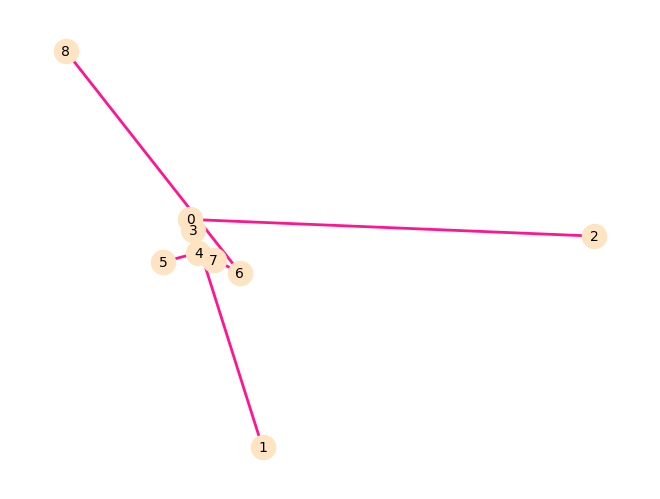

this is A_dict: 
{'0_1': [['t', 't'], ['g', 'g'], ['c', 'c'], ['t', 't'], ['a', 'a'], ['a', 'a'], ['a', 'a'], ['t', 't'], ['a', 'a'], ['g', 'g'], ['g', 'g'], ['a', 'a'], ['t', 't'], ['c', 'c'], ['c', 'c']], '0_2': [['t', 't'], ['g', 'g'], ['c', 'c'], ['t', 't'], ['a', 'a'], ['a', 'a'], ['a', 'a'], ['t', 't'], ['a', 'a'], ['g', 'g'], ['g', 'g'], ['a', 'a'], ['t', 't'], ['c', 'c'], ['c', 'c']], '0_3': [['t', 'a'], ['g', 'g'], ['c', 'c'], ['t', '-'], ['a', 'g'], ['a', 'a'], ['a', 'a'], ['t', 'c'], ['a', 'g'], ['-', 't'], ['g', 'c'], ['g', 'a'], ['a', 'a'], ['t', 'c'], ['c', 'c'], ['c', 'c']], '3_4': [['a', 'a'], ['g', 'g'], ['c', 'c'], ['g', 'g'], ['a', 'a'], ['a', 'a'], ['c', 't'], ['g', 'g'], ['t', 't'], ['c', 'c'], ['a', 'a'], ['a', 'a'], ['c', 'c'], ['c', 'c'], ['c', 'g']], '4_5': [['a', 'a'], ['g', 'g'], ['c', 'c'], ['g', 'g'], ['a', 'a'], ['a', 'a'], ['t', 'c'], ['g', 'a'], ['t', 't'], ['c', 'c'], ['a', 'a'], ['a', 'a'], ['c', 'c'], ['c', 'c'], ['g', 'a']], '4_7': [['-', 'g'], ['a',

('nr str: NA, repeats: 2, str len: 15, nr fams: 3, str_pr_fam: 3, internal var: [0.1, 0.1, 0.1], var between fams: [0.9, 0.9, 0.9], mode:family',
 ([1282], [1282], [1314]))

In [19]:
def test_many_parameters(nr_of_str=10, repeats=20,len_str=20,nr_of_fams=2, str_pr_fam=5, internal_var=0.1, var_between_fams=0.9,mode='random' ):
    if mode=='random':
        random_sequences_collection=[]
        for i in range(0,repeats):
            random_pile=[]
            for j in range (0,nr_of_str):
                a_sequence=[]
                for k in range(0,len_str):
                    a_sequence.append(random.choice(['a','c','t','g']))
                a_sequence=''.join(a_sequence)
                random_pile.append(a_sequence)
            random_sequences_collection.append(random_pile)
        costs_new_gradual=[]
        costs_new_one_by_one=[]
        costs_old=[]
        for random_pile in random_sequences_collection:
            print('rand: I intend to align: '+str(random_pile))
            cost=new_assembly(random_pile,score_matrix,gap_cost)[4]
            costs_new_gradual.append(cost)
        for random_pile in random_sequences_collection:
            cost=new_sp_approxi_combi(random_pile,score_matrix,gap_cost)[0]
            costs_new_one_by_one.append(cost)
        for random_pile in random_sequences_collection:
            print('rand:I intend to align: '+str(random_pile))
            cost=sp_approx(random_pile,score_matrix,gap_cost)[0]
            costs_old.append(cost)
    elif mode=='family':
        internal_var=[internal_var]*nr_of_fams
        var_between_fams=[var_between_fams]*nr_of_fams
        strings_in_families=make_strings_in_families(nr_of_fams,str_pr_fam,len_str,internal_var,var_between_fams)
        costs_new_gradual=[]
        costs_new_one_by_one=[]
        costs_old=[]
       # for random_pile in strings_in_families:
        print('fam:I intend to align: '+str(strings_in_families))
        cost=new_assembly(strings_in_families,score_matrix,gap_cost)[4]
        costs_new_gradual.append(cost)
        #    cost=new_assembly(random_pile,score_matrix,gap_cost)[4]
         #   costs_new_gradual.append(cost)
        #for random_pile in strings_in_families:
        cost=new_sp_approxi_combi(strings_in_families,score_matrix,gap_cost)[0]
        costs_new_one_by_one.append(cost)
        #for random_pile in strings_in_families:
        print('fam:I intend to align: '+str(strings_in_families))
        #    cost=sp_approx(random_pile,score_matrix,gap_cost)[0]
        #    costs_old.append(cost)
        cost=sp_approx(strings_in_families,score_matrix,gap_cost)[0]
        costs_old.append(cost)
        
    else:
        print("that's not a valid mode, try 'family' or 'random'!")
    #result=costs_new_gradual, costs_new_one_by_one, costs_old
    result=costs_new_gradual,costs_new_one_by_one,costs_old
    if mode=='random':
        params="nr str: "+ str(nr_of_str)+", repeats: "+str(repeats)+", str len: "+str(len_str)+", nr fams: NA, str_pr_fam: NA, internal var: NA, var between fams: NA, mode:"+str(mode)
    if mode=='family':
        params="nr str: NA, repeats: "+str(repeats)+", str len: "+str(len_str)+", nr fams: "+str(nr_of_fams)+", str_pr_fam: "+str(str_pr_fam)+", internal var: "+ str(internal_var)+", var between fams: "+str(var_between_fams)+", mode:"+str(mode)
    return params, result

test_many_parameters(repeats=2,len_str=15,nr_of_fams=3,str_pr_fam=3,internal_var=0.1,var_between_fams=0.9, mode='family')
    
        

In [ ]:
len_of_str=[5,20,50]
for k in len_of_str:
    print(type(k))

In [16]:
import csv
import pandas as pd

test_res = pd.DataFrame(columns=['params', 'results'])
repeats = 1
nr_of_str = [3, 20]
len_of_str = [5, 20,]
nr_of_fams = [2, 3, 5]
str_pr_fam = [3, 5, 10]
internal_var = [0.2, 0.8]
var_between_fams = [0.2,0.8]

csv_file_path = 'output_testing.csv'  # Specify the path to your CSV file

for i in nr_of_str:
    for j in len_of_str:
        params, results = test_many_parameters(i, repeats, mode='random')
        with open(csv_file_path, 'a', newline='') as csvfile:
            csvwriter = csv.writer(csvfile)
            csvwriter.writerow([params, results])

for k in len_of_str:
    for l in nr_of_fams:
        for m in str_pr_fam:
            for n in internal_var:
                for o in var_between_fams:
                    for p in range(0, repeats):
                        params, results = test_many_parameters(nr_of_str, repeats, k, l, m, n, o, 'family')
                        with open(csv_file_path, 'a', newline='') as csvfile:
                            csvwriter = csv.writer(csvfile)
                            csvwriter.writerow([params, results])

# Read the CSV file into a pandas DataFrame
test_res = pd.read_csv(csv_file_path)

print(test_res)


rand: I intend to align: ['gctgaggcgattcattgtag', 'gtcccatacttccggccttg', 'tgttcctgaatgttactgtt']
Here comes the distance matrix produced by the alignments: 

[[ 0. 50. 48.]
 [nan nan nan]
 [nan nan nan]]
Here comes the distance matrix produced by the alignments: 

[[ 0. 50. 48.]
 [50.  0. 50.]
 [nan nan nan]]
Here comes the distance matrix produced by the alignments: 

[[ 0. 50. 48.]
 [50.  0. 50.]
 [48. 50.  0.]]
matrix for MST: [['' '50' '0' '1']
 ['' '48' '0' '2']
 ['' '50' '1' '2']]
min span edges: [['*' '48' '0' '2']
 ['*' '50' '0' '1']
 ['' '50' '1' '2']]

 
 
 these are the nodes for the iteration 1
0 2
which correspond to these strings I align: gctgaggcgattcattgtag , tgttcctgaatgttactgtt
original alignment, which is gonna be the guide[['-', 't'], ['g', 'g'], ['c', 't'], ['t', 't'], ['g', 'c'], ['a', 'c'], ['g', 't'], ['g', 'g'], ['c', '-'], ['g', 'a'], ['a', 'a'], ['t', 't'], ['-', 'g'], ['t', 't'], ['c', 't'], ['a', 'a'], ['t', 'c'], ['t', 't'], ['g', 'g'], ['t', 't'], ['a', 

KeyboardInterrupt: 